## Business Scenario
A New York City-based real estate consultancy wants to improve its pricing strategy by more accurately estimating the market value of residential properties. Mispricing can lead to prolonged listings, missed revenue, and poor client experience.

As a data scientist at a consulting firm, the goal is to build a predictive model that estimates a property's sale price based on its physical attributes and location. This model will help real estate agents, investors, and property owners set more competitive and informed listing prices across the five boroughs of NYC.

## Business Objectives
The business objective would be to help a real estate firm in New York City accurately estimate housing prices based on property features and location. This would hel agents set competitive listing prices which would 1) reduce time on the market and 2) maximize the seller's ROI.

Success will be measured technically by RMSE, MAE, and R-squared.

Business success will be being having a model be able to make predictions within 10% of the actual sales price for at least 80% of the created test set. I will also be attempting to identify the top 5 mose influential pricing features (square footage, borough, unit count, etc).

## Dataset Overview
The dataset I have selected is from Kaggle(https://www.kaggle.com/datasets/new-york-city/nyc-property-sales/data). It includes 84,548 rows and 22 columns before cleaning. 

The dataset includes all sales from a 12 month period (September 2016-2017) in New York City.

The dataset itself directly addresses the core question: what drives property prices in NYC? It includes variables that directly influence pricing decisions such as size, age, location, building type, etc. It also reflects actual sales transactions. All of this together provides a strong foundation for a supervised machine learning model.

CAVEAT: While the dataset reflects sales from 2016–2017, our objective is not to forecast current market prices but to understand the relationship between property characteristics and value. These relationships are relatively stable over time and remain highly informative for real estate strategy. With access to more recent data, this model could be retrained for production use.

## Why Machine Learning

Real estate pricing is influenced by complex, nonlinear relationships between location, property attributes, and market various dynamics. A machine learning model is ideal for this problem because:

It can capture complex patterns and interactions among dozens of features

It scales easily across thousands of property records

It supports continuous improvement as more data becomes available

In [634]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [635]:
# pip install geopy


In [636]:
df = pd.read_csv('nyc-rolling-sales.csv')

## EDA

In [637]:
df.head(20)

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
5,9,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,405,16,,C4,516 EAST 12TH STREET,...,20,0,20,2581,9730,1900,2,C4,-,2017-07-20 00:00:00
6,10,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,,C4,210 AVENUE B,...,8,0,8,1750,4226,1920,2,C4,3192840,2016-09-23 00:00:00
7,11,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,18,,C7,520 EAST 14TH STREET,...,44,2,46,5163,21007,1900,2,C7,-,2017-07-20 00:00:00
8,12,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,379,34,,D5,141 AVENUE D,...,15,0,15,1534,9198,1920,2,D5,-,2017-06-20 00:00:00
9,13,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,,D9,629 EAST 5TH STREET,...,24,0,24,4489,18523,1920,2,D9,16232000,2016-11-07 00:00:00


Borough: in order these are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).

Building class: https://www.nyc.gov/assets/finance/jump/hlpbldgcode.html

Many sales occur with a nonsensically small dollar amount: $0 most commonly. These sales are actually transfers of deeds between parties: for example, parents transferring ownership to their home to a child after moving out for retirement. (pulled directly from Kaggle)

In [638]:
df.columns

Index(['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

In [639]:
df.info()

#will have to drop Unnamed: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  int64 
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

In [640]:
df.shape

(84548, 22)

In [641]:
df['EASE-MENT'].unique()
#will need to drop as no data

array([' '], dtype=object)

In [642]:
df['BUILDING CLASS CATEGORY'].unique()


#see link above

array(['07 RENTALS - WALKUP APARTMENTS             ',
       '08 RENTALS - ELEVATOR APARTMENTS           ',
       '09 COOPS - WALKUP APARTMENTS               ',
       '10 COOPS - ELEVATOR APARTMENTS             ',
       '11A CONDO-RENTALS                           ',
       '12 CONDOS - WALKUP APARTMENTS              ',
       '13 CONDOS - ELEVATOR APARTMENTS            ',
       '14 RENTALS - 4-10 UNIT                     ',
       '15 CONDOS - 2-10 UNIT RESIDENTIAL          ',
       '16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT ',
       '17 CONDO COOPS                             ',
       '22 STORE BUILDINGS                         ',
       '37 RELIGIOUS FACILITIES                    ',
       '42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC  ',
       '46 CONDO STORE BUILDINGS                   ',
       '47 CONDO NON-BUSINESS STORAGE              ',
       '01 ONE FAMILY DWELLINGS                    ',
       '02 TWO FAMILY DWELLINGS                    ',
       '03 THREE FAMILY DWE

In [643]:
df.isnull().sum()

Unnamed: 0                        0
BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
BLOCK                             0
LOT                               0
EASE-MENT                         0
BUILDING CLASS AT PRESENT         0
ADDRESS                           0
APARTMENT NUMBER                  0
ZIP CODE                          0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
TOTAL UNITS                       0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
YEAR BUILT                        0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE DATE                         0
dtype: int64

In [644]:
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
#change to numeric

In [645]:
df['SALE PRICE'].describe()

count    6.998700e+04
mean     1.276456e+06
std      1.140526e+07
min      0.000000e+00
25%      2.250000e+05
50%      5.300000e+05
75%      9.500000e+05
max      2.210000e+09
Name: SALE PRICE, dtype: float64

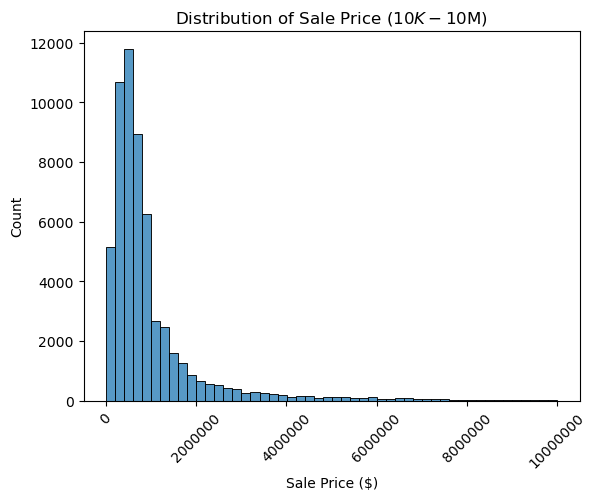

In [646]:
filtered = df[(df['SALE PRICE'] > 10_000) & (df['SALE PRICE'] < 10_000_000)]

sns.histplot(filtered['SALE PRICE'], bins=50)
plt.title('Distribution of Sale Price ($10K-$10M)')
plt.xlabel('Sale Price ($)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='x')  # Prevent scientific notation
plt.show()

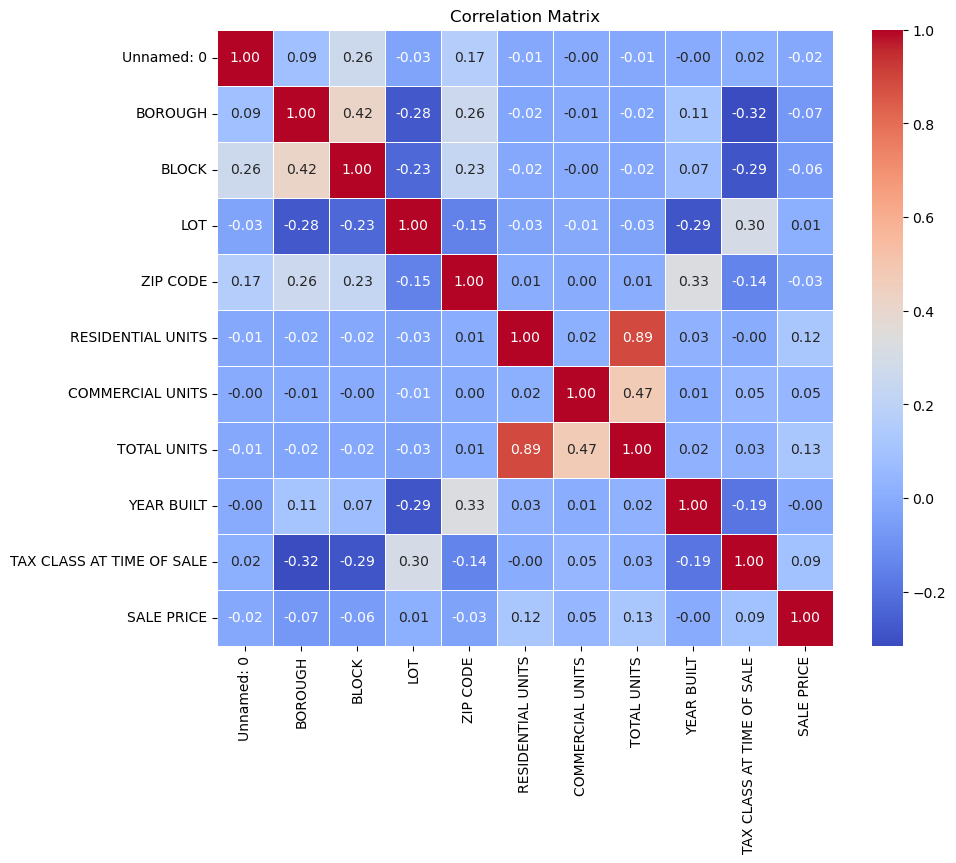

In [647]:
numeric_df = df.select_dtypes(include='number')
corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Data Cleaning

In [648]:
#drop column unnamed, EASEMENT, drop columns wehre sales price = 0

# Drop unnecessary columns
df.drop(columns=['Unnamed: 0','EASE-MENT'], errors='ignore', inplace=True)

# Drop rows where SALE PRICE is 0 or missing
df = df[df['SALE PRICE'] > 0]

In [649]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
       'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIAL UNITS',
       'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET',
       'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE',
       'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE', 'SALE DATE'],
      dtype='object')

In [650]:
#feature engineering
df['BUILDING_AGE'] = 2017 - df['YEAR BUILT']

df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['PRICE_PER_SQFT'] = df['SALE PRICE'] / df['GROSS SQUARE FEET'] #THIS SCREWS UP THE MODEL because it essentailly gives the answer

df = df[df['GROSS SQUARE FEET'] > 0]

In [651]:
df['FULL_ADDRESS'] = df['ADDRESS'].astype(str) + ', ' + df['BOROUGH'].astype(str) + ', NY ' + df['ZIP CODE'].astype(str)

In [652]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BUILDING_AGE,PRICE_PER_SQFT,FULL_ADDRESS
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,,10009,...,1633,6440.0,1900,2,C2,6625000.0,2017-07-19 00:00:00,117,1028.726708,"153 AVENUE B, 1, NY 10009"
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,,10009,...,2272,6794.0,1913,2,C4,3936272.0,2016-09-23 00:00:00,104,579.374742,"154 EAST 7TH STREET, 1, NY 10009"
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,,10009,...,2369,4615.0,1900,2,C2,8000000.0,2016-11-17 00:00:00,117,1733.477790,"301 EAST 10TH STREET, 1, NY 10009"
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,C4,210 AVENUE B,,10009,...,1750,4226.0,1920,2,C4,3192840.0,2016-09-23 00:00:00,97,755.522953,"210 AVENUE B, 1, NY 10009"
9,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,629 EAST 5TH STREET,,10009,...,4489,18523.0,1920,2,D9,16232000.0,2016-11-07 00:00:00,97,876.315932,"629 EAST 5TH STREET, 1, NY 10009"


In [653]:
from geopy.geocoders import Nominatim
import requests
import time

# Initialize geolocator
geolocator = Nominatim(user_agent="nyc_walkscore")

# Use your actual API key
api_key = '082ad7e1968c1cbba8f67068fe3f5d42'

# Step 1: Get lat/lon per ZIP
zip_latlon = {}
unique_zips = df['ZIP CODE'].dropna().unique()

for zip_code in unique_zips:
    try:
        location = geolocator.geocode(f"{zip_code}, NY")
        if location:
            zip_latlon[zip_code] = (location.latitude, location.longitude)
        else:
            zip_latlon[zip_code] = (None, None)
        time.sleep(1)
    except:
        zip_latlon[zip_code] = (None, None)

# Step 2: Fetch Walk Scores
zip_walkscore = {}

for zip_code, (lat, lon) in zip_latlon.items():
    if lat is None or lon is None:
        zip_walkscore[zip_code] = None
        continue

    url = "https://api.walkscore.com/score"
    params = {
        'format': 'json',
        'lat': lat,
        'lon': lon,
        'address': f"{zip_code}, NY",
        'wsapikey': api_key
    }

    try:
        response = requests.get(url, params=params)
        data = response.json()
        score = data.get('walkscore', None)
        zip_walkscore[zip_code] = score
        time.sleep(1)
    except:
        zip_walkscore[zip_code] = None

# Step 3: Map scores back to the main DataFrame
df['WALK_SCORE_ZIP'] = df['ZIP CODE'].map(zip_walkscore)


In [654]:
df.to_csv("nyc_housing_block_lot.csv", index=False)

In [655]:
df=pd.read_csv('nyc_housing_block_lot.csv')

Worked with chat gpt get walkscore api working. lets see if we can get model improvement!

In [656]:
df[['ZIP CODE', 'WALK_SCORE_ZIP']].dropna().head(20)

,ZIP CODE,WALK_SCORE_ZIP
0,10009,100
1,10009,100
2,10009,100
3,10009,100
4,10009,100
5,10009,100
6,10009,100
7,10009,100
8,10009,100
9,10009,100


In [657]:
df['WALK_SCORE_ZIP'].describe()


count    29334.000000
mean        83.126815
std         15.337184
min         28.000000
25%         80.000000
50%         87.000000
75%         92.000000
max        100.000000
Name: WALK_SCORE_ZIP, dtype: float64

In [658]:
print(df.shape)

(29334, 24)


In [659]:
df = df[(df['COMMERCIAL UNITS'] == 0) & (df['RESIDENTIAL UNITS'] > 0)]
#want to look at residential. commercial/mixed use has different pricing such as rental income that we do not have here. This also removes empty lots


In [660]:
df.shape

(26549, 24)

In [661]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26549 entries, 0 to 29331
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         26549 non-null  int64  
 1   NEIGHBORHOOD                    26549 non-null  object 
 2   BUILDING CLASS CATEGORY         26549 non-null  object 
 3   TAX CLASS AT PRESENT            26549 non-null  object 
 4   BLOCK                           26549 non-null  int64  
 5   LOT                             26549 non-null  int64  
 6   BUILDING CLASS AT PRESENT       26549 non-null  object 
 7   ADDRESS                         26549 non-null  object 
 8   APARTMENT NUMBER                26549 non-null  object 
 9   ZIP CODE                        26549 non-null  int64  
 10  RESIDENTIAL UNITS               26549 non-null  int64  
 11  COMMERCIAL UNITS                26549 non-null  int64  
 12  TOTAL UNITS                     26549

In [662]:
#Check for zero or null sale prices
print("Zero SALE PRICE entries:", (df['SALE PRICE'] == 0).sum())
print("Null SALE PRICE entries:", df['SALE PRICE'].isnull().sum())

# check for missing values
missing_counts = df.isnull().sum()
print("\nMissing values per column:\n", missing_counts[missing_counts > 0])

print(df.dtypes)

Zero SALE PRICE entries: 0
Null SALE PRICE entries: 0

Missing values per column:
 Series([], dtype: int64)
BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING CLASS CATEGORY            object
TAX CLASS AT PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING CLASS AT PRESENT          object
ADDRESS                            object
APARTMENT NUMBER                   object
ZIP CODE                            int64
RESIDENTIAL UNITS                   int64
COMMERCIAL UNITS                    int64
TOTAL UNITS                         int64
LAND SQUARE FEET                   object
GROSS SQUARE FEET                 float64
YEAR BUILT                          int64
TAX CLASS AT TIME OF SALE           int64
BUILDING CLASS AT TIME OF SALE     object
SALE PRICE                        float64
SALE DATE                          object
BUILDING_AGE                        int64
PRICE_PER_

In [663]:
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')

In [664]:
df.drop(columns=['COMMERCIAL UNITS'], inplace=True) #just focusing on residential

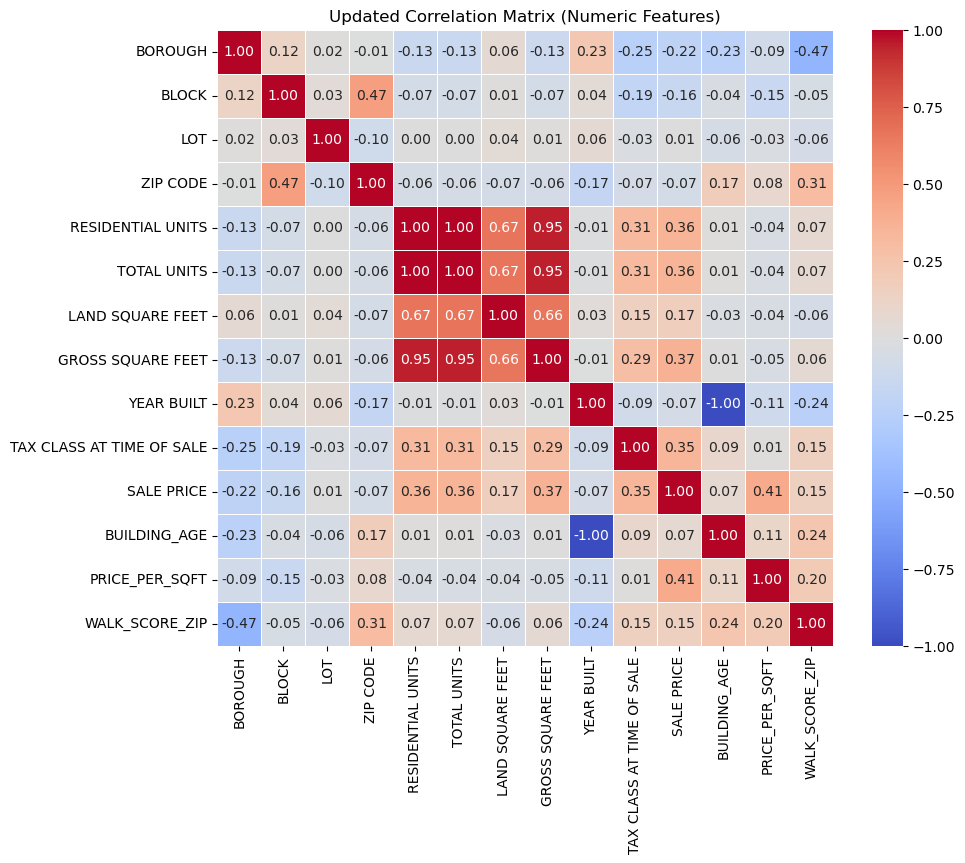

In [665]:
numeric_df = df.select_dtypes(include='number')

# Compute correlation matrix
corr = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True, linewidths=0.5)
plt.title('Updated Correlation Matrix (Numeric Features)')
plt.show()

In [666]:
corr['SALE PRICE'].sort_values(ascending=False)

SALE PRICE                   1.000000
PRICE_PER_SQFT               0.408792
GROSS SQUARE FEET            0.369633
RESIDENTIAL UNITS            0.358202
TOTAL UNITS                  0.358202
TAX CLASS AT TIME OF SALE    0.351205
LAND SQUARE FEET             0.170685
WALK_SCORE_ZIP               0.152068
BUILDING_AGE                 0.068274
LOT                          0.007734
YEAR BUILT                  -0.068274
ZIP CODE                    -0.072481
BLOCK                       -0.155657
BOROUGH                     -0.215083
Name: SALE PRICE, dtype: float64

In [667]:
#ask chatgpt for code to clean outliers in SALE PRICE, GROSS SQUARE FEET, LAND SQUARE FEET, PRICE PER SQFT

def remove_outliers_iqr(df, column, k=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

df = remove_outliers_iqr(df, 'SALE PRICE')
df = remove_outliers_iqr(df, 'GROSS SQUARE FEET')
df = remove_outliers_iqr(df, 'LAND SQUARE FEET')
df = remove_outliers_iqr(df, 'PRICE_PER_SQFT')


In [668]:
print(df.shape)


(22478, 23)


In [669]:
df['BOROUGH'] = df['BOROUGH'].replace({
    1: 'Manhattan',
    2: 'Bronx',
    3: 'Brooklyn',
    4: 'Queens',
    5: 'Staten Island'
})

In [670]:
df.head(10)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BUILDING_AGE,PRICE_PER_SQFT,FULL_ADDRESS,WALK_SCORE_ZIP
193,Manhattan,GREENWICH VILLAGE-WEST,07 RENTALS - WALKUP APARTMENTS,2A,588,32,C2,38 BARROW STREET,,10014,...,3524.0,1900,2,C2,313000.0,2017-05-23 00:00:00,117,88.819523,"38 BARROW STREET, 1, NY 10014",100
216,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1960,41,A9,307 WEST 136 STREET,,10030,...,3200.0,1910,1,A9,1510000.0,2017-01-03 00:00:00,107,471.875000,"307 WEST 136 STREET, 1, NY 10030",97
223,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,2051,62,A4,227 EDGECOMBE AVENUE,,10030,...,3360.0,1899,1,A4,1000000.0,2016-09-29 00:00:00,118,297.619048,"227 EDGECOMBE AVENUE, 1, NY 10030",97
227,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1754,116,B1,2040 MADISON AVENUE,,10035,...,3240.0,1899,1,B1,1550000.0,2017-03-30 00:00:00,118,478.395062,"2040 MADISON AVENUE, 1, NY 10035",99
232,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1937,52,B1,252 WEST 132 STREET,,10027,...,3600.0,1899,1,B1,1310000.0,2016-11-16 00:00:00,118,363.888889,"252 WEST 132 STREET, 1, NY 10027",99
234,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1941,59,B3,264 WEST 136 STREET,,10030,...,2625.0,1910,1,B3,850000.0,2017-03-27 00:00:00,107,323.809524,"264 WEST 136 STREET, 1, NY 10030",97
239,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,2041,28,B9,320 WEST 138 STREET,,10030,...,3400.0,1901,1,B9,1550000.0,2016-09-22 00:00:00,116,455.882353,"320 WEST 138 STREET, 1, NY 10030",97
250,Manhattan,HARLEM-CENTRAL,03 THREE FAMILY DWELLINGS,1,1911,4,C0,173 WEST 126 STREET,,10027,...,2596.0,1910,1,C0,60000.0,2017-06-16 00:00:00,107,23.112481,"173 WEST 126 STREET, 1, NY 10027",99
257,Manhattan,HARLEM-CENTRAL,07 RENTALS - WALKUP APARTMENTS,2A,1718,119,C3,49 WEST 119 STREET,,10026,...,2700.0,1909,2,C3,1320000.0,2017-02-28 00:00:00,108,488.888889,"49 WEST 119 STREET, 1, NY 10026",98
258,Manhattan,HARLEM-CENTRAL,07 RENTALS - WALKUP APARTMENTS,2A,1718,119,C3,49 WEST 119 STREET,,10026,...,2700.0,1909,2,C3,180000.0,2017-02-28 00:00:00,108,66.666667,"49 WEST 119 STREET, 1, NY 10026",98


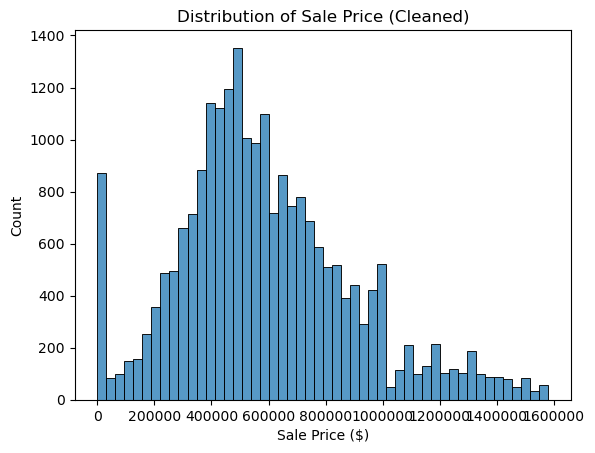

In [671]:
#show cleaned visualization
sns.histplot(df['SALE PRICE'], bins=50)
plt.title('Distribution of Sale Price (Cleaned)')
plt.xlabel('Sale Price ($)')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [672]:
df = df[df['SALE PRICE'] >= 10_000] #filtering out most family sales/deed transfers... did not use right variable as above

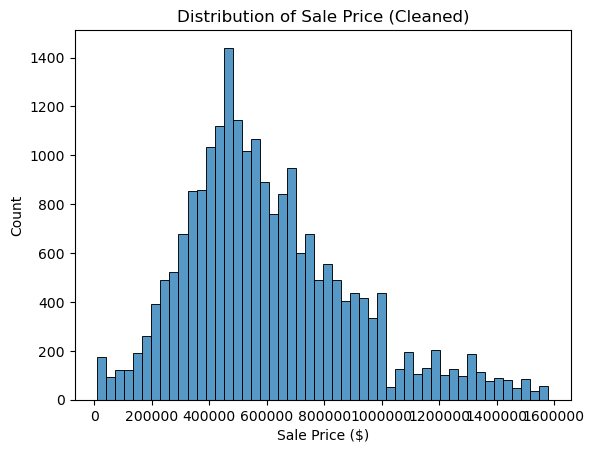

In [673]:
#show cleaned visualization
sns.histplot(df['SALE PRICE'], bins=50)
plt.title('Distribution of Sale Price (Cleaned)')
plt.xlabel('Sale Price ($)')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [674]:
df.shape

(21758, 23)

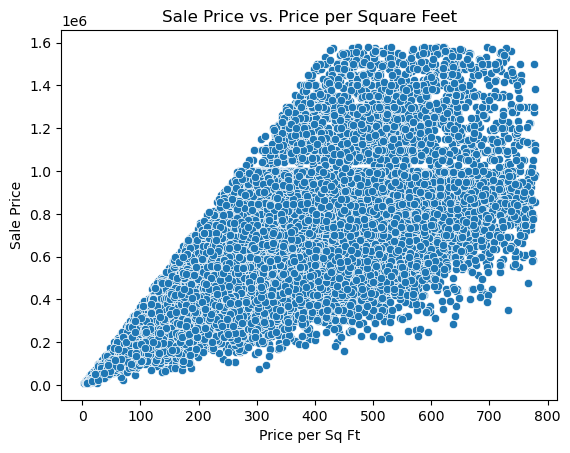

In [675]:
sns.scatterplot(data=df, x='PRICE_PER_SQFT', y='SALE PRICE')
plt.title('Sale Price vs. Price per Square Feet')
plt.xlabel('Price per Sq Ft')
plt.ylabel('Sale Price')
plt.show()

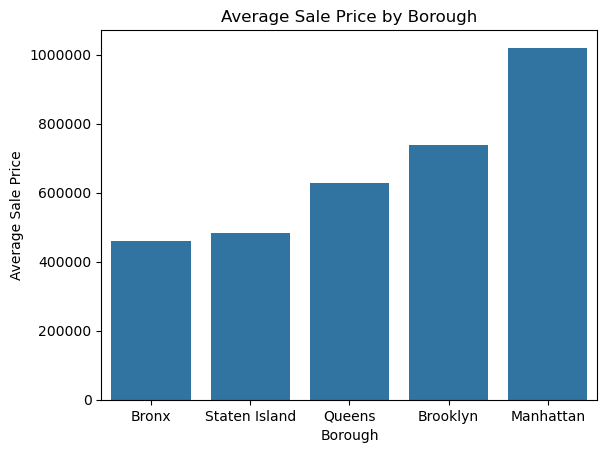

In [676]:
avg_price_by_borough = df.groupby('BOROUGH')['SALE PRICE'].mean().sort_values()

sns.barplot(x=avg_price_by_borough.index, y=avg_price_by_borough.values)
plt.title('Average Sale Price by Borough')
plt.xlabel('Borough')
plt.ylabel('Average Sale Price')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


In [677]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING CLASS CATEGORY            object
TAX CLASS AT PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING CLASS AT PRESENT          object
ADDRESS                            object
APARTMENT NUMBER                   object
ZIP CODE                            int64
RESIDENTIAL UNITS                   int64
TOTAL UNITS                         int64
LAND SQUARE FEET                  float64
GROSS SQUARE FEET                 float64
YEAR BUILT                          int64
TAX CLASS AT TIME OF SALE           int64
BUILDING CLASS AT TIME OF SALE     object
SALE PRICE                        float64
SALE DATE                          object
BUILDING_AGE                        int64
PRICE_PER_SQFT                    float64
FULL_ADDRESS                       object
WALK_SCORE_ZIP                      int64
dtype: object

In [678]:
# df.to_csv('cleaned_nyc_sales_with_walkscore.csv', index=False)


In [679]:
df_income = pd.read_csv('NYC_Household_Median_Income.csv')

In [680]:
df_income.head()

,zip,income_household_median
0,10001,123393
1,10002,46525
2,10003,153750
3,10004,220592
4,10005,211810


In [681]:
df_income.dtypes

zip                        int64
income_household_median    int64
dtype: object

In [682]:
df_income.isnull().sum()

zip                        0
income_household_median    0
dtype: int64

In [683]:
df_income.rename(columns={
    'zip': 'ZIP CODE',
    'income_household_median': 'ZIP_MEDIAN_INCOME'
}, inplace=True)

In [684]:
df = df.merge(df_income[['ZIP CODE', 'ZIP_MEDIAN_INCOME']], on='ZIP CODE', how='left')

In [685]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BUILDING_AGE,PRICE_PER_SQFT,FULL_ADDRESS,WALK_SCORE_ZIP,ZIP_MEDIAN_INCOME
0,Manhattan,GREENWICH VILLAGE-WEST,07 RENTALS - WALKUP APARTMENTS,2A,588,32,C2,38 BARROW STREET,,10014,...,1900,2,C2,313000.0,2017-05-23 00:00:00,117,88.819523,"38 BARROW STREET, 1, NY 10014",100,167254.0
1,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1960,41,A9,307 WEST 136 STREET,,10030,...,1910,1,A9,1510000.0,2017-01-03 00:00:00,107,471.875000,"307 WEST 136 STREET, 1, NY 10030",97,42738.0
2,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,2051,62,A4,227 EDGECOMBE AVENUE,,10030,...,1899,1,A4,1000000.0,2016-09-29 00:00:00,118,297.619048,"227 EDGECOMBE AVENUE, 1, NY 10030",97,42738.0
3,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1754,116,B1,2040 MADISON AVENUE,,10035,...,1899,1,B1,1550000.0,2017-03-30 00:00:00,118,478.395062,"2040 MADISON AVENUE, 1, NY 10035",99,40556.0
4,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1937,52,B1,252 WEST 132 STREET,,10027,...,1899,1,B1,1310000.0,2016-11-16 00:00:00,118,363.888889,"252 WEST 132 STREET, 1, NY 10027",99,64220.0


## Data Preprocessing

Results were very poor with current data set up. Created engineered features, changed neighborhood, and replaced zipcode with median price by zip.

In [686]:
# more feature engineering
df['SIZE_X_AGE'] = df['GROSS SQUARE FEET'] * df['BUILDING_AGE']
df['UNITS_X_SIZE'] = df['TOTAL UNITS'] * df['GROSS SQUARE FEET']

# Replace NEIGHBORHOOD with median sale price
neigh_median = df.groupby('NEIGHBORHOOD')['SALE PRICE'].median()
df['NEIGHBORHOOD_MEDIAN_PRICE'] = df['NEIGHBORHOOD'].map(neigh_median)

# Replace ZIP CODE with median price by ZIP
zip_median = df.groupby('ZIP CODE')['SALE PRICE'].median()
df['ZIP_MEDIAN_PRICE'] = df['ZIP CODE'].map(zip_median)

# # Add price per unit (avoid division by zero) this also gives the model the answer
# df['PRICE_PER_UNIT'] = df['SALE PRICE'] / df['TOTAL UNITS'].replace(0, np.nan)
# df['PRICE_PER_UNIT'] = df['PRICE_PER_UNIT'].fillna(0)

# Add "luxury". defining at over 2mil
df['IS_LUXURY'] = (df['SALE PRICE'] > 2_000_000).astype(int)

#drop unused columns
# drop_cols = ['ADDRESS', 'APARTMENT NUMBER', 'SALE DATE', 'NEIGHBORHOOD', 'ZIP CODE']
# df = df.drop(columns=drop_cols)

#updated features
categorical_features = [
    'BOROUGH',
    'BUILDING CLASS CATEGORY',
    'TAX CLASS AT PRESENT',
    'BUILDING CLASS AT PRESENT',
    'BUILDING CLASS AT TIME OF SALE',
    'IS_LUXURY'
]

numerical_features = [
    'ZIP_MEDIAN_PRICE',
    'NEIGHBORHOOD_MEDIAN_PRICE',
    'RESIDENTIAL UNITS',
    'TOTAL UNITS',
    'LAND SQUARE FEET',
    'GROSS SQUARE FEET',
    'YEAR BUILT',
    'TAX CLASS AT TIME OF SALE',
    'BUILDING_AGE',
    'SIZE_X_AGE',
    'UNITS_X_SIZE',
    'WALK_SCORE_ZIP',
    'ZIP_MEDIAN_INCOME'
]


In [687]:
df['ZIP_MEDIAN_INCOME'].fillna(df['ZIP_MEDIAN_INCOME'].median(), inplace=True)

In [688]:
X = df.drop(columns=['SALE PRICE'])
y = df['SALE PRICE']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

In [689]:
#test_train split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [690]:
X_train.isna().sum().sort_values(ascending=False)


BOROUGH                           0
NEIGHBORHOOD                      0
ZIP_MEDIAN_PRICE                  0
NEIGHBORHOOD_MEDIAN_PRICE         0
UNITS_X_SIZE                      0
SIZE_X_AGE                        0
ZIP_MEDIAN_INCOME                 0
WALK_SCORE_ZIP                    0
FULL_ADDRESS                      0
PRICE_PER_SQFT                    0
BUILDING_AGE                      0
SALE DATE                         0
BUILDING CLASS AT TIME OF SALE    0
TAX CLASS AT TIME OF SALE         0
YEAR BUILT                        0
GROSS SQUARE FEET                 0
LAND SQUARE FEET                  0
TOTAL UNITS                       0
RESIDENTIAL UNITS                 0
ZIP CODE                          0
APARTMENT NUMBER                  0
ADDRESS                           0
BUILDING CLASS AT PRESENT         0
LOT                               0
BLOCK                             0
TAX CLASS AT PRESENT              0
BUILDING CLASS CATEGORY           0
IS_LUXURY                   

In [691]:
for col in numerical_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

## Modeling

In [692]:
#LLM said this is industry standard code
base_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())])

base_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ZIP_MEDIAN_PRICE',
                                                   'NEIGHBORHOOD_MEDIAN_PRICE',
                                                   'RESIDENTIAL UNITS',
                                                   'TOTAL UNITS',
                                                   'LAND SQUARE FEET',
                                                   'GROSS SQUARE FEET',
                                                   'YEAR BUILT',
                                                   'TAX CLASS AT TIME OF SALE',
                                                   'BUILDING_AGE', 'SIZE_X_AGE',
                                                   'UNITS_X_SIZE',
                                                   'WALK_SCORE_ZIP',
                                                   'ZIP_MEDIAN_INCOME']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BOROUGH',
                                                   'BUILDING CLASS CATEGORY',
                                                   'TAX CLASS AT PRESENT',
                                                   'BUILDING CLASS AT PRESENT',
                                                   'BUILDING CLASS AT TIME OF '
                                                   'SALE',
                                                   'IS_LUXURY'])])),
                ('regressor', LinearRegression())])

In [693]:
y_pred = base_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
within_10pct = np.mean(np.abs((y_pred - y_test) / y_test) <= 0.10)


print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R²: {r2:.3f}")
print(f"% within ±10%: {within_10pct:.2%}")

RMSE: 193,781
MAE: 134,300
R²: 0.559
% within ±10%: 34.38%


Originally my baseline model was SO strong. I was confused. I had price per sqft in my numerical categories. This was essentially handing the answer to the model which was creating unreasonable results. This is a good baseline now!
Initial results
RMSE: 193,820
MAE: 134,361
R²: 0.559
% within ±10%: 34.33%

In [694]:
# #random forest
rf_preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

rf_model = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
within_10pct = np.mean(np.abs((y_pred_rf - y_test) / y_test) <= 0.10)

print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R²: {r2:.3f}")
print(f"% within ±10%: {within_10pct:.2%}")

RMSE: 191,579
MAE: 133,956
R²: 0.569
% within ±10%: 33.92%


In [695]:
#Tune RF Model

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],}

grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',  # or use 'r2', 'neg_root_mean_squared_error'
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END regressor__max_depth=None, regressor__min_samples_split=5, regressor__n_estimators=100; total time= 1.7min
[CV] END regressor__max_depth=None, regressor__min_samples_split=5, regressor__n_estimators=100; total time= 1.7min
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time= 2.5min
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time= 2.5min
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time= 2.5min
[CV] END regressor__max_depth=10, regressor__min_samples_split=2, regressor__n_estimators=100; total time=  47.4s
[CV] END regressor__max_depth=None, regressor__min_samples_split=5, regressor__n_estimators=100; total time= 1.8min
[CV] END regressor__max_depth=10, regressor__min_samples_split=2, regressor__n_estimators=100; total time=  49.2s
[CV] END regres

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ZIP_MEDIAN_PRICE',
                                                                          'NEIGHBORHOOD_MEDIAN_PRICE',
                                                                          'RESIDENTIAL '
                                                                          'UNITS',
                                                                          'TOTAL '
                                                                          'UNITS',
                                                                          'LAND '
                                                                          'SQUARE '
                                                                          'FEET',
                                                                          'GROSS '
                                                                          'SQUARE '
                                                                          'FEET',
                                                                          'YEAR '
                                                                          'BUILT',
                                                                          'TAX '
                                                                          'CLASS '
                                                                          'AT '
                                                                          'TIME '
                                                                          'OF '
                                                                          'SALE',
                                                                          'BUILDING_AGE',
                                                                          'SIZE_X_AGE',
                                                                          'UNITS_X_SIZE',
                                                                          'WALK_SCORE_ZIP',...
                                                                          'CATEGORY',
                                                                          'TAX '
                                                                          'CLASS '
                                                                          'AT '
                                                                          'PRESENT',
                                                                          'BUILDING '
                                                                          'CLASS '
                                                                          'AT '
                                                                          'PRESENT',
                                                                          'BUILDING '
                                                                          'CLASS '
                                                                          'AT '
                                                                          'TIME '
                                                                          'OF '
                                                                          'SALE',
                                                                          'IS_LUXURY'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 200]},
             scor

In [696]:
best_rf_model = grid_search.best_estimator_

y_pred_rf = best_rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
within_10pct_rf = np.mean(np.abs((y_pred_rf - y_test) / y_test) <= 0.10)

print("Best Params:", grid_search.best_params_)
print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R²: {r2:.3f}")
print(f"% within ±10%: {within_10pct_rf:.2%}")

Best Params: {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
RMSE: 186,106
MAE: 129,769
R²: 0.594
% within ±10%: 34.19%


In [697]:
# #try xgb boost
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
])

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
within_10pct = np.mean(np.abs((y_pred - y_test) / y_test) <= 0.10)

print("XGBoost Results:")
print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R²: {r2:.3f}")
print(f"% within ±10%: {within_10pct:.2%}")

XGBoost Results:
RMSE: 191,813
MAE: 131,919
R²: 0.568
% within ±10%: 34.72%


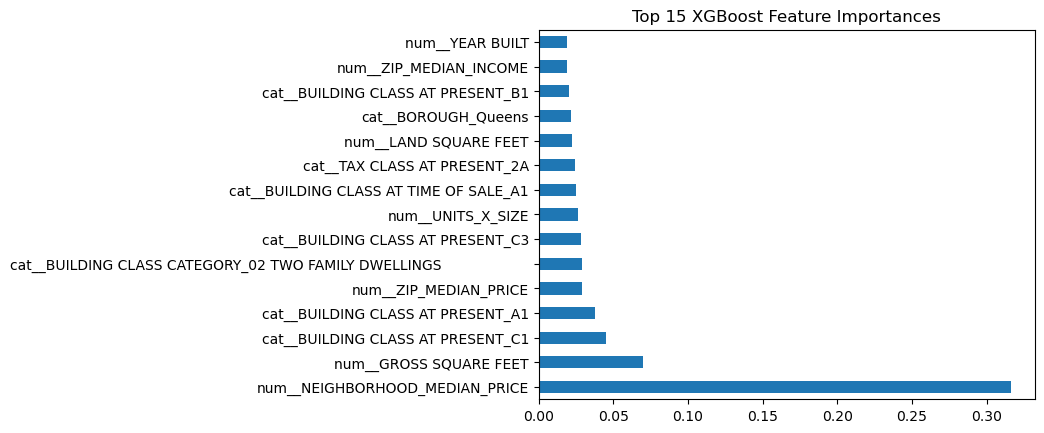

In [698]:
importances = xgb_model.named_steps['regressor'].feature_importances_
features = xgb_model.named_steps['preprocessor'].get_feature_names_out()

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp.head(15).plot(kind='barh')
plt.title("Top 15 XGBoost Feature Importances")
plt.show()

In [699]:

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(
    xgb_model,  
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.4s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.6s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.6s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.6s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=6, regressor__n_estimators=100; total time=   0.8s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=6, regressor__n_estimators=100; total time=   0.9s
[CV] END regressor__learning_rate=0.01, reg

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ZIP_MEDIAN_PRICE',
                                                                          'NEIGHBORHOOD_MEDIAN_PRICE',
                                                                          'RESIDENTIAL '
                                                                          'UNITS',
                                                                          'TOTAL '
                                                                          'UNITS',
                                                                          'LAND '
                                                                          'SQUARE '
                                                                          'FEET',
                                                                          'GROSS '
                                                                          'SQUARE '
                                                                          'FEET',
                                                                          'YEAR '
                                                                          'BUILT',
                                                                          'TAX '
                                                                          'CLASS '
                                                                          'AT '
                                                                          'TIME '
                                                                          'OF '
                                                                          'SALE',
                                                                          'BUILDING_AGE',
                                                                          'SIZE_X_AGE',
                                                                          'UNITS_X_SIZE',
                                                                          'WALK_SCORE_ZIP',...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=-1,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.01, 0.1, 0.2],
                         'regressor__max_depth': [3, 6, 10],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_absolute_error', verbose=2)

In [700]:
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
within_10pct = np.mean(np.abs((y_pred - y_test) / y_test) <= 0.10)

print("Tuned XGBoost Results:")
print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R²: {r2:.3f}")
print(f"% within ±10%: {within_10pct:.2%}")


Tuned XGBoost Results:
RMSE: 186,367
MAE: 128,922
R²: 0.592
% within ±10%: 34.33%


In [701]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,BUILDING_AGE,PRICE_PER_SQFT,FULL_ADDRESS,WALK_SCORE_ZIP,ZIP_MEDIAN_INCOME,SIZE_X_AGE,UNITS_X_SIZE,NEIGHBORHOOD_MEDIAN_PRICE,ZIP_MEDIAN_PRICE,IS_LUXURY
0,Manhattan,GREENWICH VILLAGE-WEST,07 RENTALS - WALKUP APARTMENTS,2A,588,32,C2,38 BARROW STREET,,10014,...,117,88.819523,"38 BARROW STREET, 1, NY 10014",100,167254.0,412308.0,17620.0,313000.0,313000.0,0
1,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1960,41,A9,307 WEST 136 STREET,,10030,...,107,471.875000,"307 WEST 136 STREET, 1, NY 10030",97,42738.0,342400.0,3200.0,1300000.0,1272013.0,0
2,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,2051,62,A4,227 EDGECOMBE AVENUE,,10030,...,118,297.619048,"227 EDGECOMBE AVENUE, 1, NY 10030",97,42738.0,396480.0,3360.0,1300000.0,1272013.0,0
3,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1754,116,B1,2040 MADISON AVENUE,,10035,...,118,478.395062,"2040 MADISON AVENUE, 1, NY 10035",99,40556.0,382320.0,6480.0,1300000.0,1493750.0,0
4,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1937,52,B1,252 WEST 132 STREET,,10027,...,118,363.888889,"252 WEST 132 STREET, 1, NY 10027",99,64220.0,424800.0,7200.0,1300000.0,1193000.0,0


In [702]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="nyc-housing-model")

# Example
location = geolocator.geocode("10001, New York, NY")
print(location.latitude, location.longitude)

40.7484675 -73.9941134


In [ ]:
# unique_zips = df['ZIP CODE'].unique()
# zip_to_coords = {}

# for z in unique_zips:
#     loc = geolocator.geocode(f"{z}, New York, NY")
#     if loc:
#         zip_to_coords[z] = (loc.latitude, loc.longitude)

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=10029%2C+New+York%2C+NY&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

In [705]:
df['ZIP_LAT'] = df['ZIP CODE'].map(lambda x: zip_to_coords.get(x, (None, None))[0])
df['ZIP_LON'] = df['ZIP CODE'].map(lambda x: zip_to_coords.get(x, (None, None))[1])


In [706]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,FULL_ADDRESS,WALK_SCORE_ZIP,ZIP_MEDIAN_INCOME,SIZE_X_AGE,UNITS_X_SIZE,NEIGHBORHOOD_MEDIAN_PRICE,ZIP_MEDIAN_PRICE,IS_LUXURY,ZIP_LAT,ZIP_LON
0,Manhattan,GREENWICH VILLAGE-WEST,07 RENTALS - WALKUP APARTMENTS,2A,588,32,C2,38 BARROW STREET,,10014,...,"38 BARROW STREET, 1, NY 10014",100,167254.0,412308.0,17620.0,313000.0,313000.0,0,40.733938,-74.004932
1,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1960,41,A9,307 WEST 136 STREET,,10030,...,"307 WEST 136 STREET, 1, NY 10030",97,42738.0,342400.0,3200.0,1300000.0,1272013.0,0,40.818100,-73.943115
2,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,2051,62,A4,227 EDGECOMBE AVENUE,,10030,...,"227 EDGECOMBE AVENUE, 1, NY 10030",97,42738.0,396480.0,3360.0,1300000.0,1272013.0,0,40.818100,-73.943115
3,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1754,116,B1,2040 MADISON AVENUE,,10035,...,"2040 MADISON AVENUE, 1, NY 10035",99,40556.0,382320.0,6480.0,1300000.0,1493750.0,0,40.794488,-73.941639
4,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1937,52,B1,252 WEST 132 STREET,,10027,...,"252 WEST 132 STREET, 1, NY 10027",99,64220.0,424800.0,7200.0,1300000.0,1193000.0,0,40.810465,-73.950531


In [707]:
# Load the updated dataset
sub_df = pd.read_csv('MTA_Subway_Entrances_and_Exits__2024.csv')


In [708]:
sub_df.columns

Index(['Division', 'Line', 'Borough', 'Stop Name', 'Complex ID',
       'Constituent Station Name', 'Station ID', 'GTFS Stop ID',
       'Daytime Routes', 'Entrance Type', 'Entry Allowed', 'Exit Allowed',
       'Entrance Latitude', 'Entrance Longitude', 'entrance_georeference'],
      dtype='object')

In [709]:
# Extract lat/lon and rename
subway_coords = sub_df[['Entrance Latitude', 'Entrance Longitude']].dropna()
subway_coords.columns = ['SUB_LAT', 'SUB_LON']

In [710]:
#copied directly from chatgpt to compute subway distance
from math import radians, sin, cos, sqrt, atan2

def haversine_vec(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

# For each property row, compute distance to every subway point and take min
def min_subway_distance(row, subway_coords):
    return subway_coords.apply(
        lambda sub: haversine_vec(row['ZIP_LAT'], row['ZIP_LON'], sub['SUB_LAT'], sub['SUB_LON']),
        axis=1
    ).min()

# Apply to your whole dataset
df['DIST_TO_SUBWAY_KM'] = df.apply(
    lambda row: min_subway_distance(row, subway_coords),
    axis=1
)

In [711]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,WALK_SCORE_ZIP,ZIP_MEDIAN_INCOME,SIZE_X_AGE,UNITS_X_SIZE,NEIGHBORHOOD_MEDIAN_PRICE,ZIP_MEDIAN_PRICE,IS_LUXURY,ZIP_LAT,ZIP_LON,DIST_TO_SUBWAY_KM
0,Manhattan,GREENWICH VILLAGE-WEST,07 RENTALS - WALKUP APARTMENTS,2A,588,32,C2,38 BARROW STREET,,10014,...,100,167254.0,412308.0,17620.0,313000.0,313000.0,0,40.733938,-74.004932,0.154113
1,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1960,41,A9,307 WEST 136 STREET,,10030,...,97,42738.0,342400.0,3200.0,1300000.0,1272013.0,0,40.818100,-73.943115,0.345145
2,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,2051,62,A4,227 EDGECOMBE AVENUE,,10030,...,97,42738.0,396480.0,3360.0,1300000.0,1272013.0,0,40.818100,-73.943115,0.345145
3,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1754,116,B1,2040 MADISON AVENUE,,10035,...,99,40556.0,382320.0,6480.0,1300000.0,1493750.0,0,40.794488,-73.941639,0.222430
4,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1937,52,B1,252 WEST 132 STREET,,10027,...,99,64220.0,424800.0,7200.0,1300000.0,1193000.0,0,40.810465,-73.950531,0.158694


In [712]:
df['DIST_TO_SUBWAY_KM'].corr(df['SALE PRICE'])
#see correlation between newly created subway distance

0.1054840306052183

In [713]:
#new features list
categorical_features_two = [
    'BOROUGH',
    'BUILDING CLASS CATEGORY',
    'TAX CLASS AT PRESENT',
    'BUILDING CLASS AT PRESENT',
    'BUILDING CLASS AT TIME OF SALE',
    'IS_LUXURY'
]

numerical_features_two = [
    'ZIP_MEDIAN_PRICE',
    'NEIGHBORHOOD_MEDIAN_PRICE',
    'RESIDENTIAL UNITS',
    'TOTAL UNITS',
    'LAND SQUARE FEET',
    'GROSS SQUARE FEET',
    'YEAR BUILT',
    'TAX CLASS AT TIME OF SALE',
    'BUILDING_AGE',
    'SIZE_X_AGE',
    'UNITS_X_SIZE',
    'WALK_SCORE_ZIP',
    'ZIP_MEDIAN_INCOME',
    'DIST_TO_SUBWAY_KM'
]


In [714]:
X = df[categorical_features_two + numerical_features_two]
y = df['SALE PRICE']

# Step 2: Re-split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [715]:
#new Preprocessor
preprocessor_two = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_two),
    ('num', StandardScaler(), numerical_features_two)
])

# Pipeline (base — reused for GridSearchCV)
xgb_model_two = Pipeline(steps=[
    ('preprocessor', preprocessor_two),
    ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
])

In [716]:
grid_search = GridSearchCV(
    xgb_model_two,
    param_grid=param_grid,  # reuse your original param grid
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.5s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.6s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.7s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   1.0s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   1.1s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   1.1s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=6, regressor__n_estimators=100; total time=   1.3s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=6, regressor__n_estimators=100; total time=   1.5s
[CV] END regressor__learning_rate=0.01, reg

In [717]:
y_pred = best_xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
within_10pct = np.mean(np.abs((y_pred - y_test) / y_test) <= 0.10)

print("Tuned XGBoost With Subway Distance:")
print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R²: {r2:.3f}")
print(f"% within ±10%: {within_10pct:.2%}")

Tuned XGBoost With Subway Distance:
RMSE: 186,458
MAE: 129,000
R²: 0.592
% within ±10%: 34.33%


In [718]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
       'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIAL UNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'BUILDING_AGE', 'PRICE_PER_SQFT',
       'FULL_ADDRESS', 'WALK_SCORE_ZIP', 'ZIP_MEDIAN_INCOME', 'SIZE_X_AGE',
       'UNITS_X_SIZE', 'NEIGHBORHOOD_MEDIAN_PRICE', 'ZIP_MEDIAN_PRICE',
       'IS_LUXURY', 'ZIP_LAT', 'ZIP_LON', 'DIST_TO_SUBWAY_KM'],
      dtype='object')

In [719]:
df_pluto = pd.read_csv('pluto_25v1_1.csv')

Talked to gpt about how to improve modeling. Suggested I incorporate PLUTO dataset from NYC.gov

In [720]:
df_pluto.head()

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,...,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
0,SI,6020,28,503.0,5017013.0,5.017013e+10,170.10,2000.0,31.0,51.0,...,NaN,NaN,1,NaN,NaN,25v1.1,NaN,40.557352,-74.196460,NaN
1,SI,1183,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,NaN,NaN,25v1.1,t,NaN,NaN,NaN
2,QN,15100,575,414.0,4107202.0,4.107202e+10,1072.02,2.0,NaN,32.0,...,NaN,NaN,4,1.0,1.0,25v1.1,NaN,40.606646,-73.815428,NaN
3,MN,1371,30,106.0,1010601.0,1.010601e+10,106.01,1.0,NaN,5.0,...,NaN,NaN,4,1.0,1.0,25v1.1,t,40.755686,-73.960747,NaN
4,SI,7722,200,503.0,5024402.0,5.024402e+10,244.02,1.0,NaN,51.0,...,NaN,NaN,5,1.0,1.0,25v1.1,NaN,40.496841,-74.234707,NaN


In [721]:
df_pluto.shape

(858629, 92)

In [722]:
df_pluto.columns

Index(['borough', 'block', 'lot', 'cd', 'bct2020', 'bctcb2020', 'ct2010',
       'cb2010', 'schooldist', 'council', 'zipcode', 'firecomp', 'policeprct',
       'healthcenterdistrict', 'healtharea', 'sanitboro', 'sanitdistrict',
       'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3',
       'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3',
       'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements',
       'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea',
       'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea',
       'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext',
       'proxcode', 'irrlotcode', 'lottype', 'bsmtcode', 'assessland',
       'assesstot', 'exempttot', 'yearbuilt', 'yearalter1', 'yearalter2',
       'histdist', 'landmark', 'builtfar', 'residfar', 'commfar', 'facilfar',
       'borocode', 'bbl', 'cond

In [723]:
df_pluto = pd.read_csv("pluto_25v1_1.csv", dtype={'BBL': str}) #convert bbl to string

In [724]:
df_pluto.columns = df_pluto.columns.str.upper()
print(df_pluto[['BBL', 'LATITUDE', 'LONGITUDE']].head())

            BBL   LATITUDE  LONGITUDE
0  5.060200e+09  40.557352 -74.196460
1  5.011830e+09        NaN        NaN
2  4.151001e+09  40.606646 -73.815428
3  1.013710e+09  40.755686 -73.960747
4  5.077220e+09  40.496841 -74.234707


In [725]:
df_pluto['BBL'] = df_pluto['BBL'].fillna(0).astype('int64').astype(str).str.zfill(10) #was having issues getting BBL converted to string properly

In [726]:
print(df_pluto['BBL'].head())

0    5060200028
1    5011830073
2    4151000575
3    1013710030
4    5077220200
Name: BBL, dtype: object


In [727]:
#for sake of merging pluto. Get real coordinates instead of zip coordinates using bbl. (borough block lot). need to generate BBL column

borough_map = {
    'Manhattan': '1',
    'Bronx': '2',
    'Brooklyn': '3',
    'Queens': '4',
    'Staten Island': '5'
}

df['BBL_BOROUGH'] = df['BOROUGH'].map(borough_map)
df['BBL'] = (
    df['BBL_BOROUGH'].astype(str).str.zfill(1) +
    df['BLOCK'].astype(str).str.zfill(5) +
    df['LOT'].astype(str).str.zfill(4)
)

In [728]:
df = df.merge(
    df_pluto[['BBL', 'LATITUDE', 'LONGITUDE']],
    on='BBL',
    how='left')

In [729]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,...,NEIGHBORHOOD_MEDIAN_PRICE,ZIP_MEDIAN_PRICE,IS_LUXURY,ZIP_LAT,ZIP_LON,DIST_TO_SUBWAY_KM,BBL_BOROUGH,BBL,LATITUDE,LONGITUDE
0,Manhattan,GREENWICH VILLAGE-WEST,07 RENTALS - WALKUP APARTMENTS,2A,588,32,C2,38 BARROW STREET,,10014,...,313000.0,313000.0,0,40.733938,-74.004932,0.154113,1,1005880032,40.732308,-74.004261
1,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1960,41,A9,307 WEST 136 STREET,,10030,...,1300000.0,1272013.0,0,40.818100,-73.943115,0.345145,1,1019600041,40.817599,-73.946476
2,Manhattan,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,2051,62,A4,227 EDGECOMBE AVENUE,,10030,...,1300000.0,1272013.0,0,40.818100,-73.943115,0.345145,1,1020510062,40.823310,-73.944361
3,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1754,116,B1,2040 MADISON AVENUE,,10035,...,1300000.0,1493750.0,0,40.794488,-73.941639,0.222430,1,1017540116,40.808592,-73.938876
4,Manhattan,HARLEM-CENTRAL,02 TWO FAMILY DWELLINGS,1,1937,52,B1,252 WEST 132 STREET,,10027,...,1300000.0,1193000.0,0,40.810465,-73.950531,0.158694,1,1019370052,40.813913,-73.946941


In [730]:
#for clarity

df.rename(columns={
    'LATITUDE': 'REAL_LAT',
    'LONGITUDE': 'REAL_LON'
}, inplace=True)

In [731]:
#same code as before, but now using real alt and long

# Haversine function (unchanged)
def haversine_vec(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

# Updated version to use REAL_LAT and REAL_LON
def min_subway_distance(row, subway_coords):
    return subway_coords.apply(
        lambda sub: haversine_vec(row['REAL_LAT'], row['REAL_LON'], sub['SUB_LAT'], sub['SUB_LON']),
        axis=1
    ).min()

# Compute for all rows — this will still be slow on large datasets
df['DIST_TO_SUBWAY_KM'] = df.apply(
    lambda row: min_subway_distance(row, subway_coords),
    axis=1
)


In [732]:
df.to_csv("nyc_housing_with_subway_distance.csv", index=False)

In [733]:
MIDTOWN_LAT = 40.7580
MIDTOWN_LON = -73.9855
#times square... going to compute distance to times square. seems like could be good indicator of value 
#per google

In [734]:
df['DIST_TO_MIDTOWN_KM'] = df.apply(
    lambda row: haversine_vec(row['REAL_LAT'], row['REAL_LON'], MIDTOWN_LAT, MIDTOWN_LON),
    axis=1
)

In [735]:
print(df['DIST_TO_MIDTOWN_KM'].describe())
print("Correlation with SALE PRICE:", df['DIST_TO_MIDTOWN_KM'].corr(df['SALE PRICE']))
#yay real correlation!

count    21642.000000
mean        17.016555
std          5.381771
min          3.264921
25%         13.317586
50%         16.632244
75%         20.140097
max         36.102351
Name: DIST_TO_MIDTOWN_KM, dtype: float64
Correlation with SALE PRICE: -0.29790598146881786


In [736]:
numerical_features_two.append('DIST_TO_MIDTOWN_KM')
numerical_features_two.append('DIST_TO_SUBWAY_KM')


In [737]:
numerical_features_two = list(set(numerical_features_two))

In [738]:
# Updated preprocessor
preprocessor_two = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_two),
    ('num', StandardScaler(), numerical_features_two)
])

# Rebuild pipeline for GridSearchCV
xgb_model_two = Pipeline(steps=[
    ('preprocessor', preprocessor_two),
    ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
])

In [739]:
X = df[categorical_features_two + numerical_features_two]
y = df['SALE PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [740]:
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(
    xgb_model_two,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.5s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.5s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.5s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.8s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.8s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.8s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=6, regressor__n_estimators=100; total time=   1.3s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=6, regressor__n_estimators=100; total time=   1.3s
[CV] END regressor__learning_rate=0.01, reg

In [741]:
y_pred = best_xgb.predict(X_test)

print("Tuned XGBoost with DIST_TO_MIDTOWN_KM:")
print(f"R²: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):,.0f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):,.0f}")
print(f"% within ±10%: {np.mean(np.abs((y_pred - y_test) / y_test) <= 0.10):.2%}")

Tuned XGBoost with DIST_TO_MIDTOWN_KM:
R²: 0.594
MAE: 128,754
RMSE: 186,007
% within ±10%: 34.47%
